In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('RELIANCE.csv')

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature Engineering
df['Open-Close'] = df['Open'] - df['Close']
df['High-Low'] = df['High'] - df['Low']
df


,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low
Date,,,,,,,,
2023-04-03,2164.434326,2168.126221,2136.744141,2151.927490,2144.352783,5146521,12.506836,31.382080
2023-04-05,2167.203125,2167.203125,2130.791016,2146.758789,2139.202148,8131464,20.444336,36.412109
2023-04-06,2139.651611,2172.741211,2139.651611,2161.157471,2153.550049,9217523,-21.505860,33.089600
2023-04-10,2169.049316,2169.418457,2142.789795,2145.835693,2138.282227,6480704,23.213623,26.628662
2023-04-11,2154.281250,2160.742188,2145.097412,2156.450195,2148.859375,5271183,-2.168945,15.644776
...,...,...,...,...,...,...,...,...
2024-03-27,2896.000000,3000.000000,2894.000000,2985.699951,2985.699951,8163322,-89.699951,106.000000
2024-03-28,2985.750000,3011.899902,2957.300049,2971.699951,2971.699951,10927182,14.050049,54.599853
2024-04-01,2984.949951,2987.949951,2965.000000,2969.550049,2969.550049,2506940,15.399902,22.949951


In [8]:
# Define predictor variables (X) and target variable (y)
X = df[['Open-Close', 'High-Low']]
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# Split the data into training and testing sets
split_percentage = 0.8
split = int(split_percentage * len(df))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
# Train SVC
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [10]:
# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate RandomForestClassifier using cross-validation
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy')

print("Cross-Validation Mean Accuracy for RandomForest:", np.mean(cv_scores_rf))

Cross-Validation Mean Accuracy for RandomForest: 0.525


In [11]:
# Predictions on testing set for best SVC model
test_predictions_svc = svc.predict(X_test)
test_accuracy_svc = accuracy_score(y_test, test_predictions_svc)

# Predictions on testing set for RandomForestClassifier
test_predictions_rf = rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)

print("Testing Accuracy for Best SVC Model:", test_accuracy_svc)
print("Testing Accuracy for RandomForest Classifier:", test_accuracy_rf)

Testing Accuracy for Best SVC Model: 0.48
Testing Accuracy for RandomForest Classifier: 0.42


In [12]:
# Visualize the results
df['Predicted_Signal_SVC'] = svc.predict(X)
df['Predicted_Signal_RF'] = rf.predict(X)

df['Return'] = df['Close'].pct_change()
df['Strategy_Return_SVC'] = df['Return'] * df['Predicted_Signal_SVC'].shift(1)
df['Strategy_Return_RF'] = df['Return'] * df['Predicted_Signal_RF'].shift(1)

df['Cumulative_Return_SVC'] = df['Strategy_Return_SVC'].cumsum()
df['Cumulative_Return_RF'] = df['Strategy_Return_RF'].cumsum()

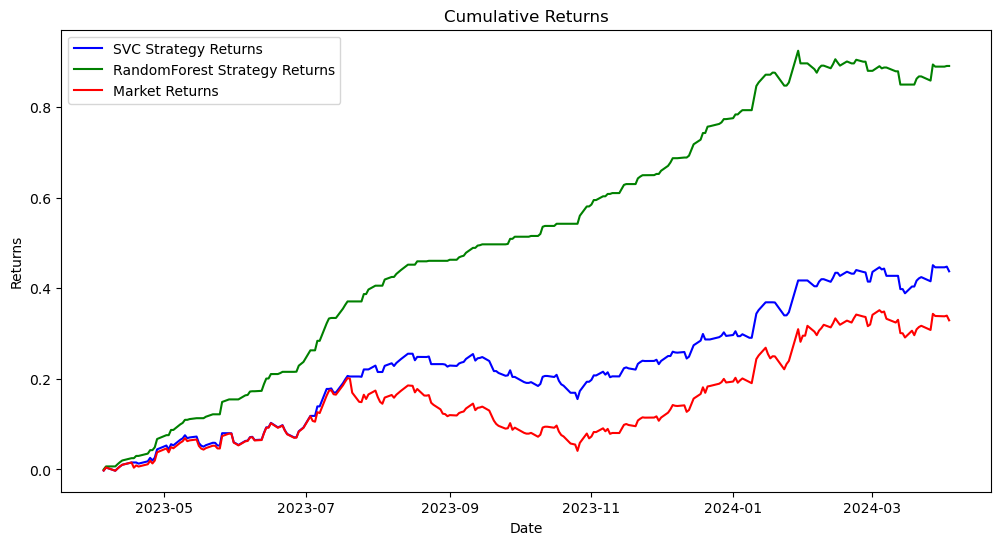

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Return_SVC'], label='SVC Strategy Returns', color='blue')
plt.plot(df['Cumulative_Return_RF'], label='RandomForest Strategy Returns', color='green')
plt.plot(df['Return'].cumsum(), label='Market Returns', color='red')
plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()